In [ ]:
#Mounting the drive to link with the data
import os
from google.colab import drive
drive.mount('/content/gdrive')
print(os.listdir("/content/gdrive/My Drive/Thesis Earthquake Data/"))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
['EarthquakeDataR.csv', 'output.html', 'EarthquakeDataImp.csv', 'EarthquakeDataTime.csv', 'earthquake.csv', 'EarthquakeDataArima.csv', 'data.csv', 'datasets_92906_216379_bankloans.csv', 'datasets_531_1056_german_credit_data.csv', 'datasets_531_1056_german_credit_data.xlsx', 'FeatureImp.PNG']


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as stats
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 9
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.inspection import plot_partial_dependence


<Figure size 864x648 with 0 Axes>

In [ ]:
#Importing the pre-processed data to save time with pandas.
CreditRisk = pd.read_csv('/content/gdrive/My Drive/Thesis Earthquake Data/datasets_92906_216379_bankloans.csv')

In [ ]:
CreditRisk.head(10)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0
5,41,2,5,5,25,10.2,0.392700,2.157300,0.0
6,39,1,20,9,67,30.6,3.833874,16.668126,0.0
7,43,1,12,11,38,3.6,0.128592,1.239408,0.0
8,24,1,3,4,19,24.4,1.358348,3.277652,1.0
9,36,1,0,13,25,19.7,2.777700,2.147300,0.0


In [ ]:
#Checking the data types of the features
CreditRisk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [ ]:
#Checking the number of null values present in the features. It shows there are 150 values missing in our dependent variable.
CreditRisk.isnull().sum()

age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     150
dtype: int64

In [ ]:
#Creating copies of the dataframe with mean and median to check the standard deviation and then decide the imputation method.
CreditRiskMean = CreditRisk.copy()
CreditRiskMedian = CreditRisk.copy()

In [ ]:
CreditRiskMean.fillna(CreditRiskMean.mean(), inplace=True)
CreditRiskMean.isnull().sum()
print(CreditRiskMean.describe())

              age          ed      employ  ...    creddebt     othdebt     default
count  850.000000  850.000000  850.000000  ...  850.000000  850.000000  850.000000
mean    35.029412    1.710588    8.565882  ...    1.576805    3.078789    0.261429
std      8.041432    0.927784    6.777884  ...    2.125840    3.398803    0.398995
min     20.000000    1.000000    0.000000  ...    0.011696    0.045584    0.000000
25%     29.000000    1.000000    3.000000  ...    0.382176    1.045942    0.000000
50%     34.000000    1.000000    7.000000  ...    0.885091    2.003243    0.000000
75%     41.000000    2.000000   13.000000  ...    1.898440    3.903001    0.261429
max     56.000000    5.000000   33.000000  ...   20.561310   35.197500    1.000000

[8 rows x 9 columns]


In [ ]:
CreditRiskMedian.fillna(CreditRiskMedian.median(), inplace=True)
CreditRiskMedian.isnull().sum()
print(CreditRiskMedian.describe())

              age          ed      employ  ...    creddebt     othdebt     default
count  850.000000  850.000000  850.000000  ...  850.000000  850.000000  850.000000
mean    35.029412    1.710588    8.565882  ...    1.576805    3.078789    0.215294
std      8.041432    0.927784    6.777884  ...    2.125840    3.398803    0.411268
min     20.000000    1.000000    0.000000  ...    0.011696    0.045584    0.000000
25%     29.000000    1.000000    3.000000  ...    0.382176    1.045942    0.000000
50%     34.000000    1.000000    7.000000  ...    0.885091    2.003243    0.000000
75%     41.000000    2.000000   13.000000  ...    1.898440    3.903001    0.000000
max     56.000000    5.000000   33.000000  ...   20.561310   35.197500    1.000000

[8 rows x 9 columns]


#After comparing the standard deviation of "default" with mean and median it seems the imputed data is less deviated from the mean with mean imputation technique. hence will be progressing with it.

In [ ]:
#Taking the mean imputed data into the main dataframe
CreditRisk = CreditRiskMean

In [ ]:
#converting all the features into numeric data type for modelling purpose
CreditRisk['default'] = CreditRisk['default'].astype(int)
CreditRisk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   850 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 59.9 KB


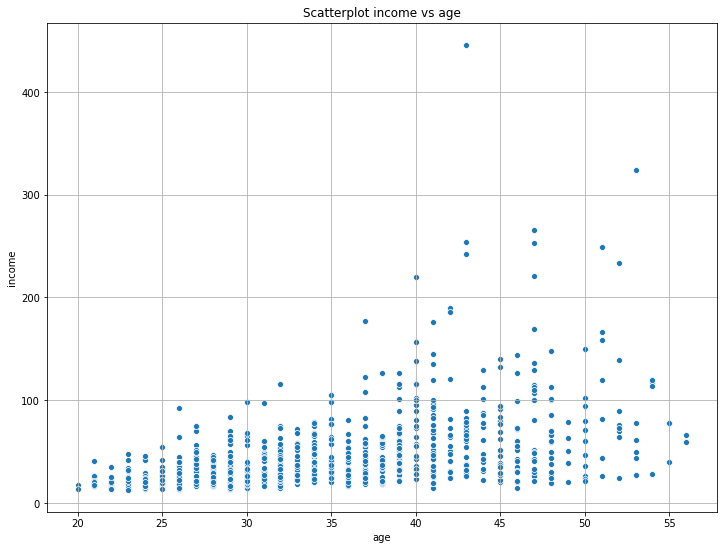

In [ ]:
import seaborn as sns
sns.scatterplot(x="age", y="income", data=CreditRisk);
plt.title('Scatterplot income vs age')
plt.show()

#The income increases mostly in the age group of 40-50.

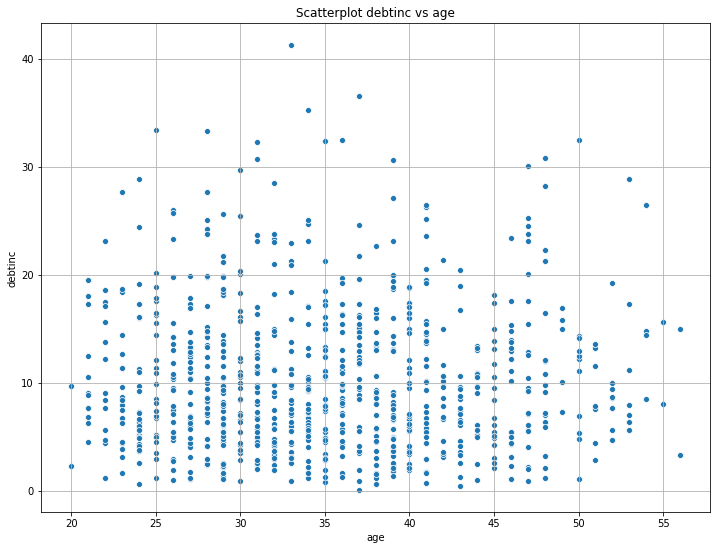

In [ ]:
sns.scatterplot(x="age", y="debtinc", data=CreditRisk);
plt.title('Scatterplot debtinc vs age')
plt.show()
#age group of 30-40 have higher debtinc ratio than others. and are paying max interest from their income

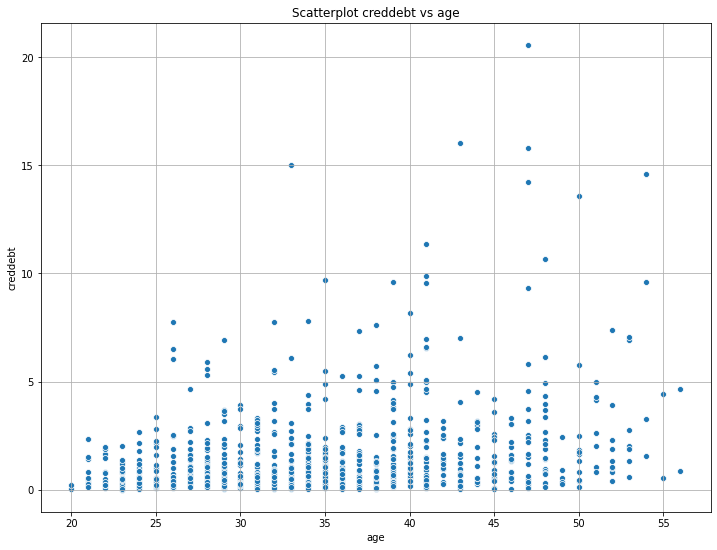

In [ ]:
sns.scatterplot(x="age", y="creddebt", data=CreditRisk);
plt.title('Scatterplot creddebt vs age')
plt.show()
#The Creddebt ratio can be seen more in the age of 45-50

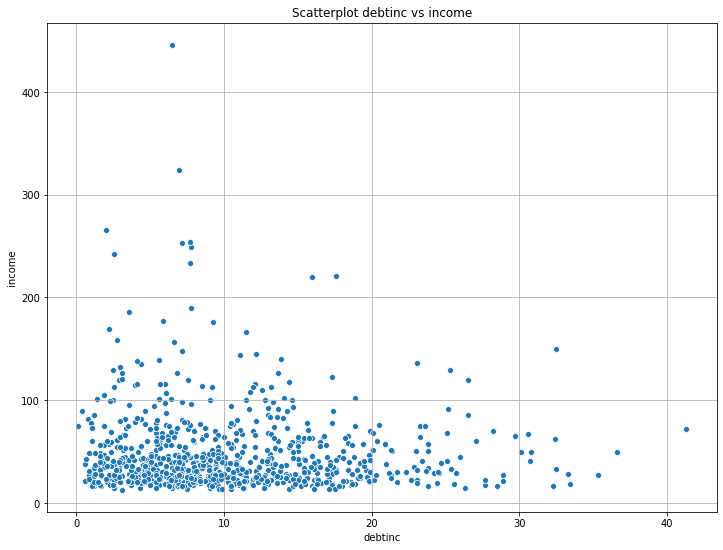

In [ ]:
sns.scatterplot(x="debtinc", y="income", data=CreditRisk);
plt.title('Scatterplot debtinc vs income')
plt.show()
#No insight or relation found in here.

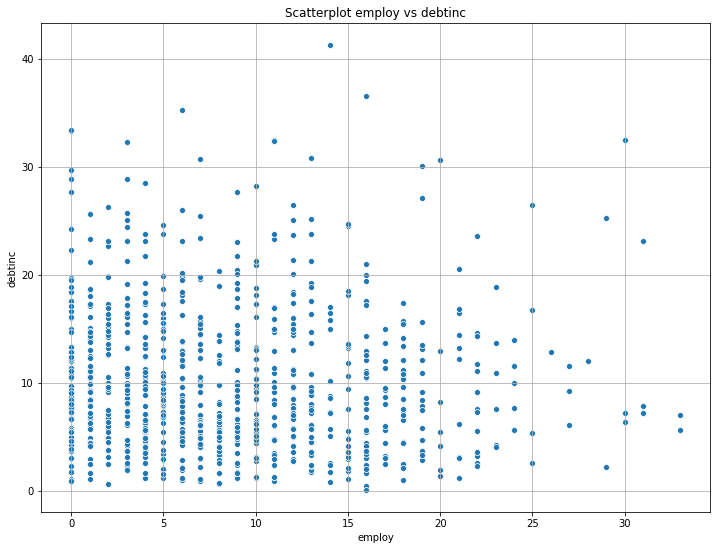

In [ ]:
sns.scatterplot(x="employ", y="debtinc", data=CreditRisk);
plt.title('Scatterplot employ vs debtinc')
plt.show()
#customers with higher employment years with a company have less debtinc

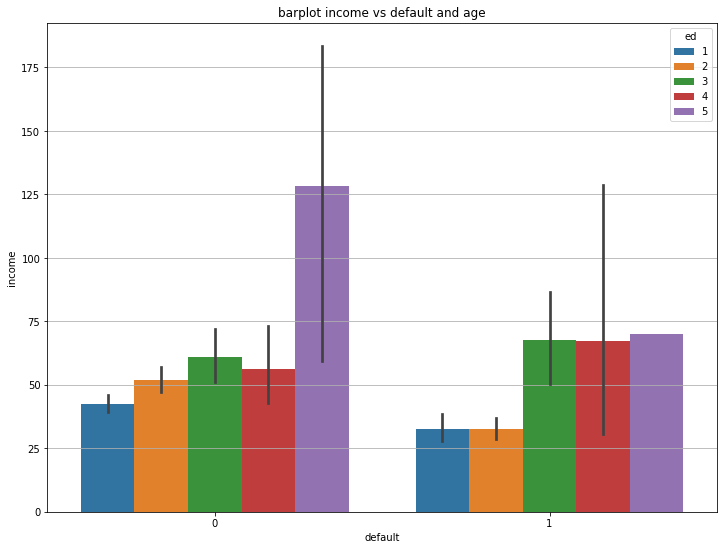

In [ ]:
sns.barplot(x="default", y="income", hue="ed" ,data=CreditRisk);
plt.title('barplot income vs default and ed level')
plt.show()
#There are defaulters amongst the higher education levels specifically between 3,4,5

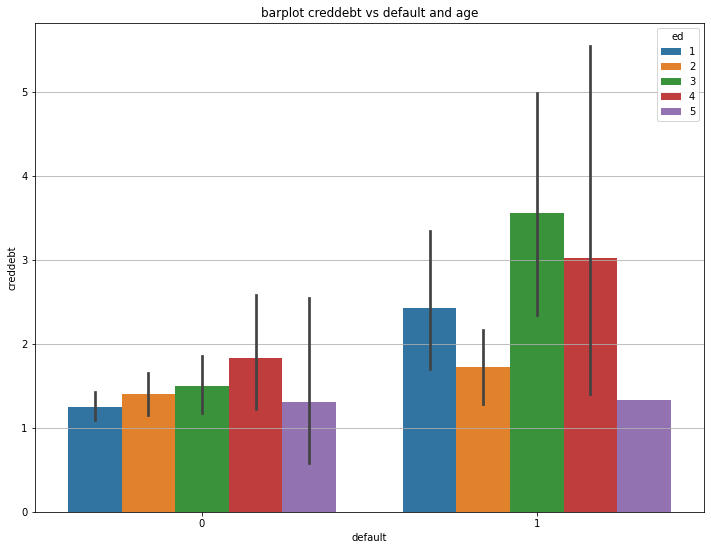

In [ ]:
sns.barplot(x="default", y="creddebt",hue="ed", data=CreditRisk);
plt.title('barplot creddebt vs default and ed level')
plt.show()
#The creddebt is highest amongst education level 3 and 4.

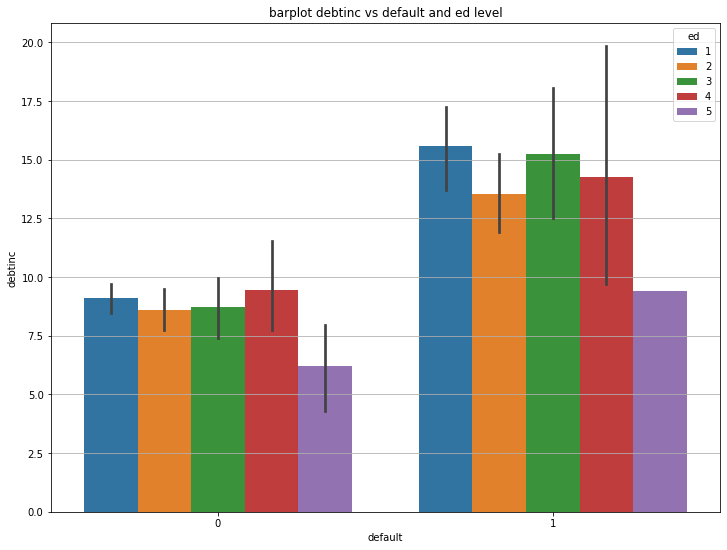

In [ ]:
sns.barplot(x="default", y="debtinc", hue = "ed", data=CreditRisk);
plt.title('barplot debtinc vs default and ed level')
plt.show()
#The debt income is maximum amongst the level 1,3 and 4 amongst the defaulters

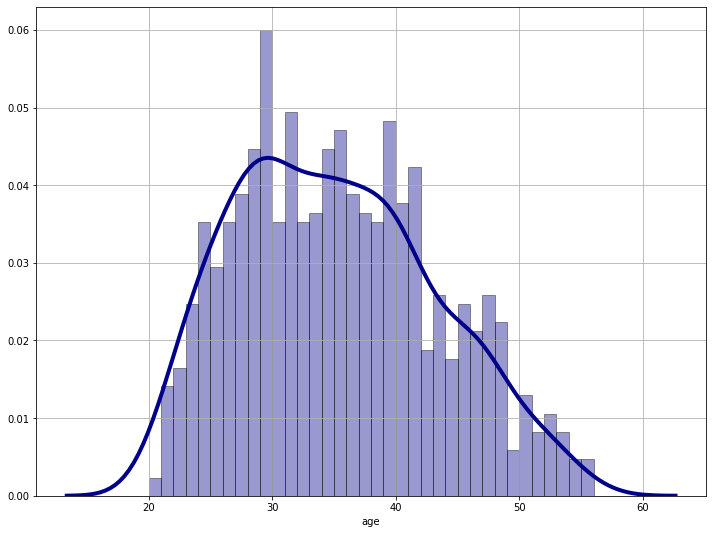

In [ ]:
#Checking the skweness of the data AGE
sns.distplot(CreditRisk['age'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

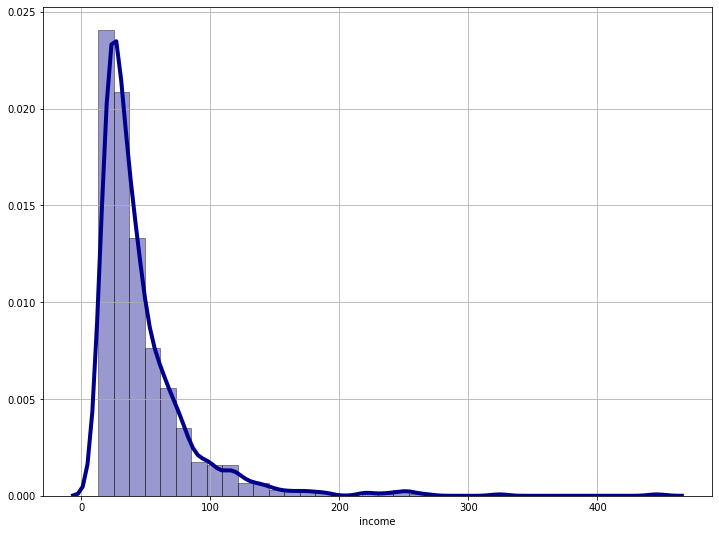

In [ ]:
#Checking the skweness of the data Income
sns.distplot(CreditRisk['income'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

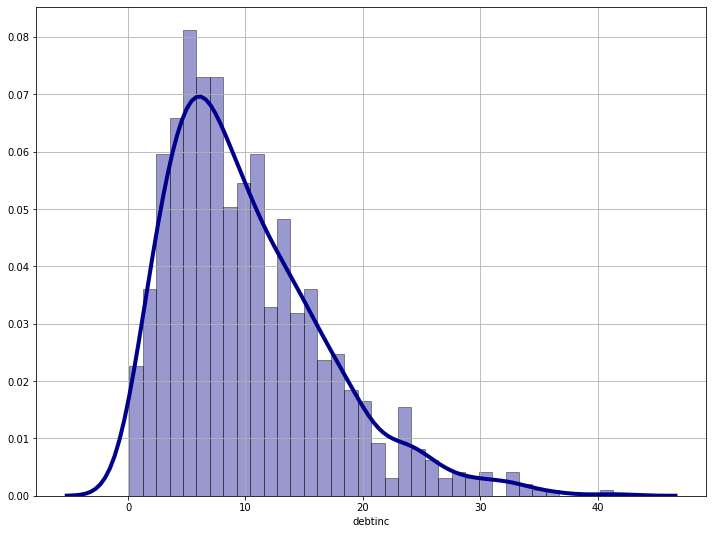

In [ ]:
#Checking the skweness of the data DebtInc
sns.distplot(CreditRisk['debtinc'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

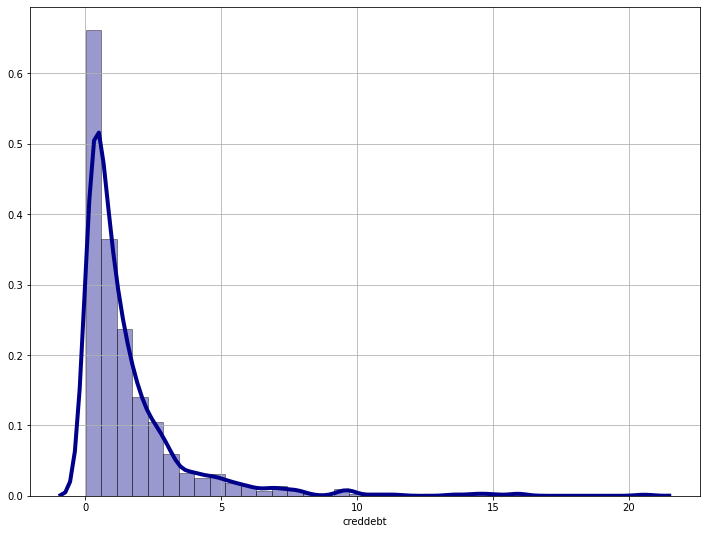

In [ ]:
#Checking the skweness of the data Creddebt
sns.distplot(CreditRisk['creddebt'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

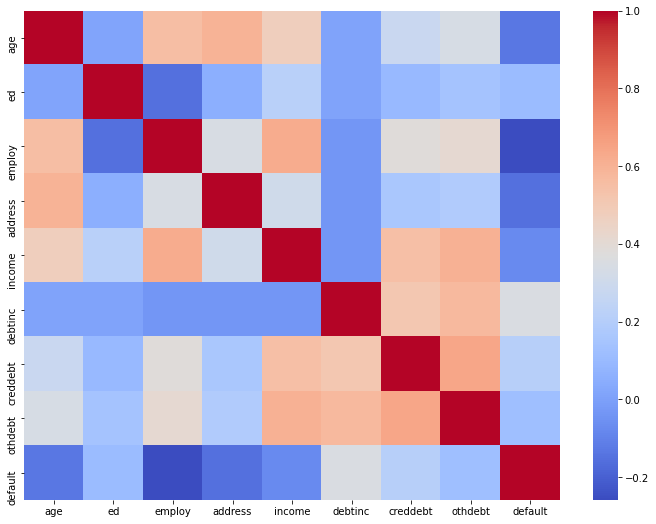

In [ ]:
#Checking the corelation amongst the variables.
sns.heatmap(CreditRisk.corr(),cmap='coolwarm');

In [ ]:
#Number of different counts in default
CreditRisk.default.value_counts(ascending=False)

0    667
1    183
Name: default, dtype: int64

In [ ]:
#Number of different counts in education level
CreditRisk.ed.value_counts(ascending=False)

1    460
2    235
3    101
4     49
5      5
Name: ed, dtype: int64

In [ ]:
#Squareroot transformation was performed for positivley skewed data.
import numpy as np
CreditRisk = np.sqrt(CreditRisk)

In [ ]:
CreditRisk.head(10)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,6.403124,1.732051,4.123106,3.464102,13.266499,3.049590,3.370370,2.237992,1.0
1,5.196152,1.000000,3.162278,2.449490,5.567764,4.159327,1.167134,2.000199,0.0
2,6.324555,1.000000,3.872983,3.741657,7.416198,2.345208,0.925243,1.472727,0.0
3,6.403124,1.000000,3.872983,3.741657,10.954451,1.702939,1.630558,0.906245,0.0
4,4.898979,1.414214,1.414214,0.000000,5.291503,4.159327,1.336950,1.748303,1.0
5,6.403124,1.414214,2.236068,2.236068,5.000000,3.193744,0.626658,1.468775,0.0
6,6.244998,1.000000,4.472136,3.000000,8.185353,5.531727,1.958028,4.082662,0.0
7,6.557439,1.000000,3.464102,3.316625,6.164414,1.897367,0.358597,1.113287,0.0
8,4.898979,1.000000,1.732051,2.000000,4.358899,4.939636,1.165482,1.810429,1.0
9,6.000000,1.000000,0.000000,3.605551,5.000000,4.438468,1.666643,1.465367,0.0


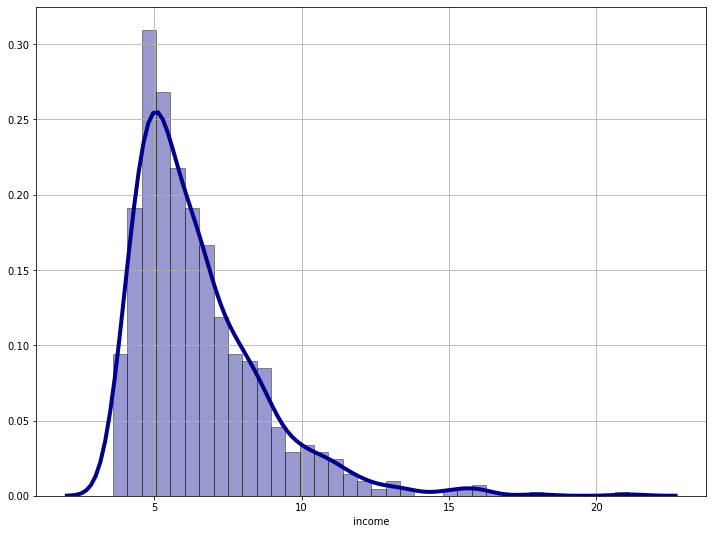

In [ ]:
#Checking the skweness of the data Income after applying squareroot transformation
sns.distplot(CreditRisk['income'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.utils import resample

In [ ]:
# Splitting the data into train and test.
# Separate input features and target
y = CreditRisk.default
X = CreditRisk.drop('default', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=27)

In [ ]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
601,6.403124,1.000000,4.898979,3.464102,9.110434,3.741657,2.566815,2.243092,0.0
507,5.000000,1.000000,3.000000,1.414214,4.472136,1.870829,0.324037,0.771362,0.0
12,7.211103,1.000000,4.898979,3.741657,8.000000,3.162278,1.982322,1.571751,0.0
35,5.099020,1.414214,2.449490,2.645751,6.708204,5.099020,2.459451,2.377204,0.0
829,6.782330,2.000000,2.645751,4.000000,8.544004,1.048809,0.745437,0.497317,0.0


In [ ]:
# separate minority and majority classes 0 being not defaulted(667) and 1 being defaulted(183)
not_default = X[X.default==0]
default = X[X.default==1]

# upsample minority
default_upsampled = resample(default,
                          replace=True, # sample with replacement
                          n_samples=len(not_default), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_default, default_upsampled])

# check new class counts
upsampled.default.value_counts()

1.0    468
0.0    468
Name: default, dtype: int64

In [ ]:
# trying randomforest classifier again with the balanced dataset
y_train = upsampled.default
X_train = upsampled.drop('default', axis=1)

In [ ]:
#Applying the model on test data set
upsampled = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
upsampled_pred = upsampled.predict(X_test)

In [ ]:
#To check the overfitting model was also executed on train data.
upsampled_train_pred = upsampled.predict(X_train)

In [ ]:
# Train Checking accuracy
accuracy_score(y_train, upsampled_train_pred)

0.9989316239316239

In [ ]:
# Test Checking accuracy
accuracy_score(y_test, upsampled_pred)

0.7647058823529411

In [ ]:
# f1 score
f1_score(y_test, upsampled_pred)

0.375

In [ ]:
y_test.value_counts()

0.0    199
1.0     56
Name: default, dtype: int64

In [ ]:
# confusion matrix
pd.DataFrame(confusion_matrix(y_test, upsampled_pred))
#TN FP
#FN TP

,0,1
0,177,22
1,38,18


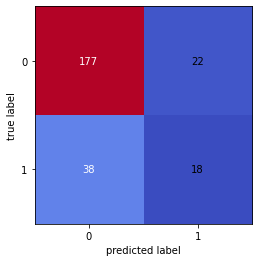

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

CFH = np.array([[177, 22],
                [38, 18]])

fig, ax = plot_confusion_matrix(conf_mat=CFH,figsize=(4, 4),cmap="coolwarm")
plt.show()

In [ ]:
print("recall score")
print(recall_score(y_test, upsampled_pred))
print("precision score")
print(precision_score(y_test, upsampled_pred))

recall score
0.30357142857142855
precision score
0.4473684210526316


In [ ]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, upsampled_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.599021895190237


Text(0.5, 0, 'False Positive Rate')

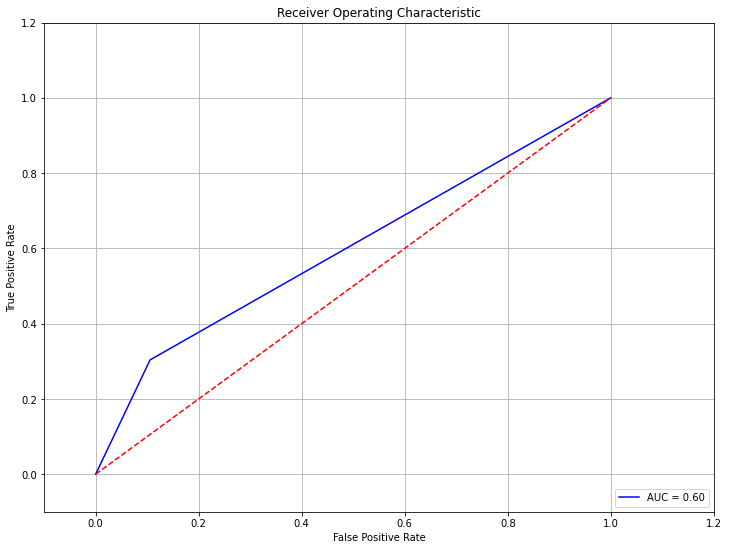

In [ ]:
#Plotting the ROC Curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
#After checking with a simple split the model was overfitting hence deciding to go with grid search to run the model with best parameters.
#Hyperparameter Tuning by GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#defining the parameters
n_estimators=[50,100,150,200]
max_features=['auto','sqrt','log2']
max_depth=[10,20,30,40,50]
max_depth.append
min_samples_split = [2,5,10,15,20]
min_samples_leaf = [1,2,5,10,15]


grid_param = { 
    'n_estimators' : n_estimators,
    'max_features' : max_features,
     'max_depth' : max_depth,
     'min_samples_split' : min_samples_split,
     'min_samples_leaf' : min_samples_leaf 

}
#Implementing Grid Search hyper parameter tuning.
from sklearn.model_selection import GridSearchCV
upsampled_grid = RandomForestClassifier(random_state=1)
#kfold = KFold(n_splits=5, random_state=7)
upsampled_grid = GridSearchCV(estimator=upsampled_grid,param_grid=grid_param,cv=5,verbose=2,n_jobs=-1)
upsampled_train_pred_hyper = upsampled_grid.fit(X_train,y_train)
print(upsampled_grid.best_params_)
expected_y  = y_test
upsampled_train_pred_hyper = upsampled_grid.predict(X_train)
upsampled_pred_hyper = upsampled_grid.predict(X_test)
print("The best parameters are :")
print(upsampled_grid.best_params_)




Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 6841 tasks      | elapsed: 22.1min


{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
The best parameters are :
{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 24.3min finished


In [ ]:
# Checking train accuracy
print("Training accuracy:")
print(accuracy_score(y_train, upsampled_train_pred_hyper))
# Checking test accuracy
print("Testing accuracy:")
print(accuracy_score(y_test, upsampled_pred_hyper))
# f1 score
print("F1 Score:")
print(f1_score(y_test, upsampled_pred_hyper))

Training accuracy:
1.0
Testing accuracy:
0.788235294117647
F1 Score:
0.47058823529411764


In [ ]:
# confusion matrix
CFH = pd.DataFrame(confusion_matrix(y_test, upsampled_pred_hyper))
print(CFH)
#TN FP
#FN TP

     0   1
0  177  22
1   32  24


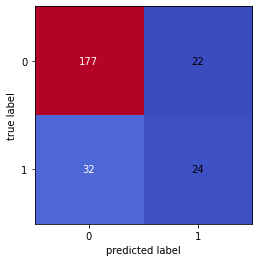

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

CFH = np.array([[177, 22],
                [32, 24]])

fig, ax = plot_confusion_matrix(conf_mat=CFH,figsize=(4, 4),cmap="coolwarm")
plt.show()

In [ ]:
#Recall and Precision Score
print("recall score")
print(recall_score(y_test, upsampled_pred_hyper))
print("precision score")
print(precision_score(y_test, upsampled_pred_hyper))

recall score
0.42857142857142855
precision score
0.5217391304347826


In [ ]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, upsampled_pred_hyper)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.6590093323761665


Text(0.5, 0, 'False Positive Rate')

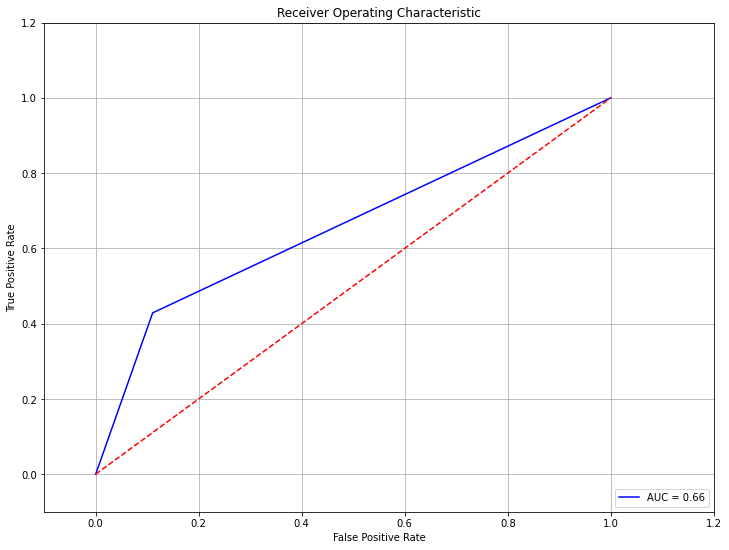

In [ ]:
#Plotting the ROC Curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

After classifying the defaulters with respect to the features customer segmentation could be done according to age and DebtIncome ratio and credit debit ratio to determine the risk of giving loans.

In [ ]:
#Preparing the dataframe for clustering.
CreditRiskCluster = CreditRiskMean

In [ ]:
CreditRiskCluster

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.000000
1,27,1,10,6,31,17.3,1.362202,4.000798,0.000000
2,40,1,15,14,55,5.5,0.856075,2.168925,0.000000
3,41,1,15,14,120,2.9,2.658720,0.821280,0.000000
4,24,2,2,0,28,17.3,1.787436,3.056564,1.000000
...,...,...,...,...,...,...,...,...,...
845,34,1,12,15,32,2.7,0.239328,0.624672,0.261429
846,32,2,12,11,116,5.7,4.026708,2.585292,0.261429
847,48,1,13,11,38,10.8,0.722304,3.381696,0.261429
848,35,2,1,11,24,7.8,0.417456,1.454544,0.261429


In [ ]:
#Choosing the features for clustering
Clusters = pd.DataFrame()
Clusters['debtinc'] = CreditRiskCluster['debtinc']
Clusters['age'] = CreditRiskCluster['age']
Clusters['income'] = CreditRiskCluster['income']
Clusters['employ'] = CreditRiskCluster['employ']
Clusters.head()

,debtinc,age,income,employ
0,9.3,41,176,17
1,17.3,27,31,10
2,5.5,40,55,15
3,2.9,41,120,15
4,17.3,24,28,2


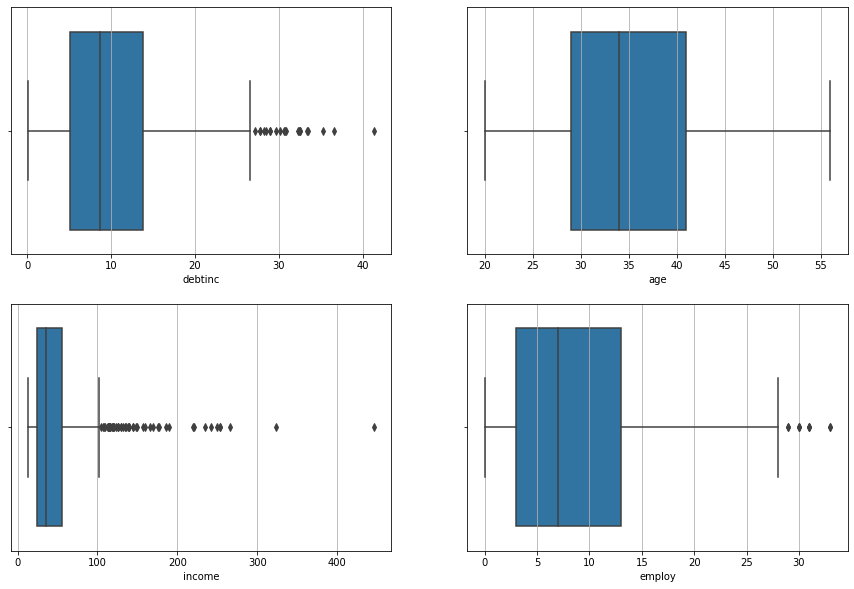

In [ ]:
#Income and DebtIncome consists of maximum outliers.
numerical = ['debtinc','age','income','employ']
fig = plt.figure(figsize = (15,10))
axes = 220
for num in numerical:
    axes += 1
    fig.add_subplot(axes)
    sns.boxplot(data = Clusters, x = num)
plt.show()

In [ ]:
CreditRiskMean.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

No handles with labels found to put in legend.


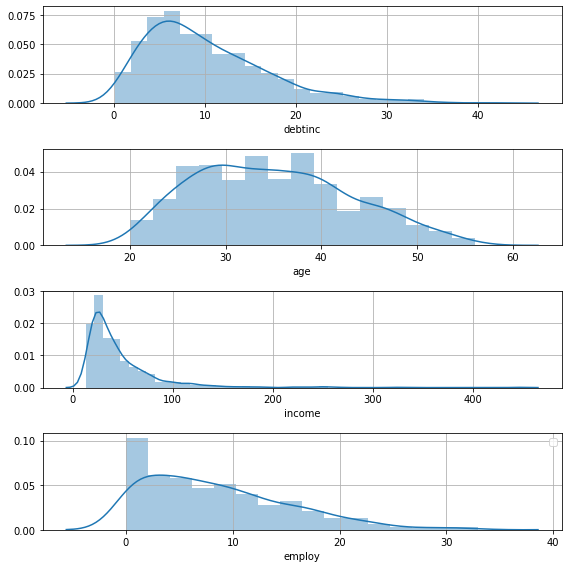

In [ ]:
#Checking the distributions of the features.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(8,8))
sns.distplot(Clusters["debtinc"], ax=ax1)
sns.distplot(Clusters["age"], ax=ax2)
sns.distplot(Clusters["income"], ax=ax3)
sns.distplot(Clusters["employ"], ax=ax4)
plt.tight_layout()
plt.legend()

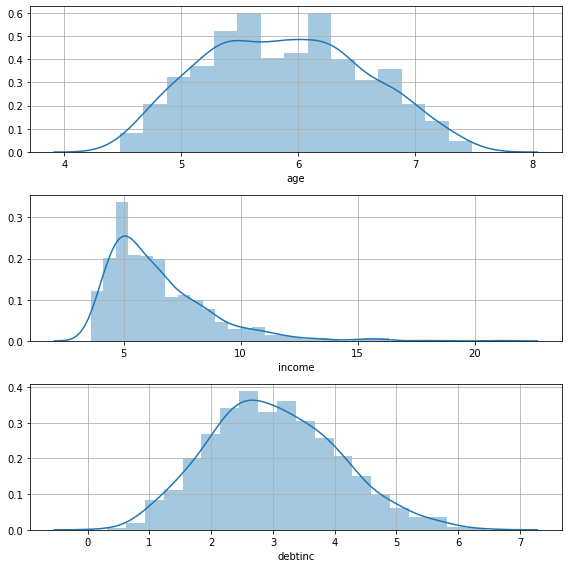

In [ ]:
#Square-root transformation to normalise the features.
import numpy as np
Clusters_sqrt = np.sqrt(Clusters[['age', 'income','debtinc','employ']])

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
sns.distplot(Clusters_sqrt["age"], ax=ax1)
sns.distplot(Clusters_sqrt["income"], ax=ax2)
sns.distplot(Clusters_sqrt["debtinc"], ax=ax3)
sns.distplot(Clusters_sqrt["employ"], ax=ax4)
plt.tight_layout()

In [ ]:
Clusters_sqrt.head()

,age,income,debtinc,employ
0,6.403124,13.266499,3.049590,4.123106
1,5.196152,5.567764,4.159327,3.162278
2,6.324555,7.416198,2.345208,3.872983
3,6.403124,10.954451,1.702939,3.872983
4,4.898979,5.291503,4.159327,1.414214


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(Clusters_sqrt)

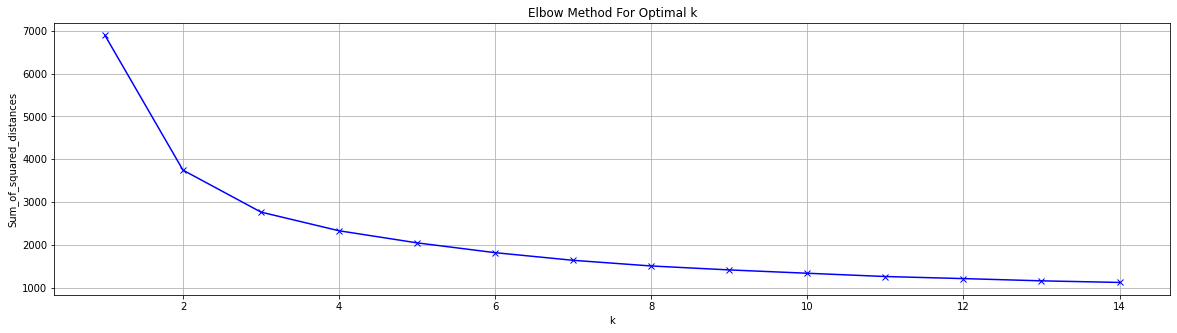

In [ ]:
#Implementing K-means algorithm
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Clusters_sqrt)
    Sum_of_squared_distances.append(km.inertia_)
plt.figure(figsize=(20,5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

K-Means


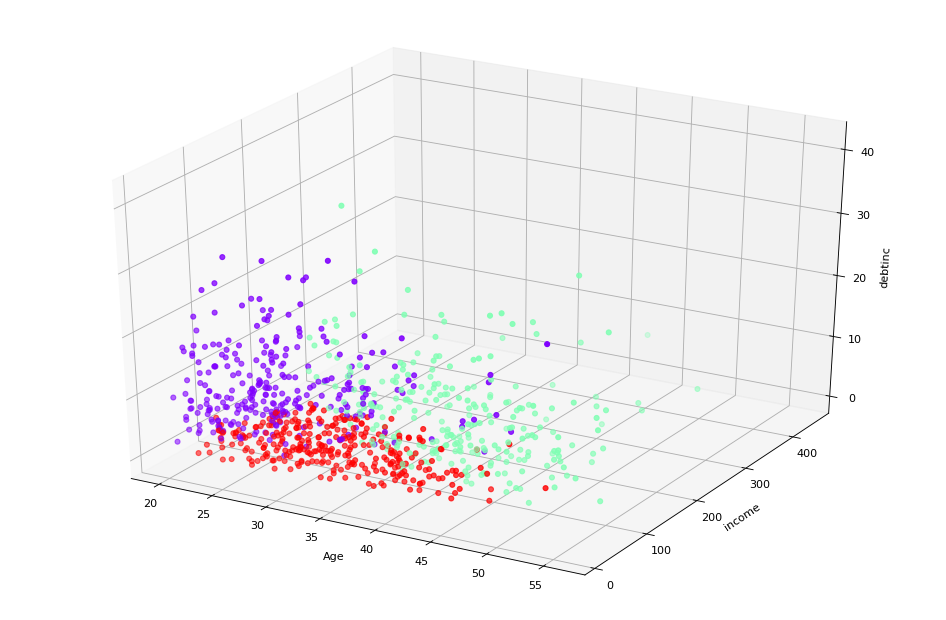

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

model = KMeans(n_clusters=3)
model.fit(cluster_scaled)
kmeans_labels = model.labels_

fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(Clusters['age'],Clusters['income'],Clusters['debtinc'],c=kmeans_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('income', linespacing=3.1)
zLabel = ax.set_zlabel('debtinc', linespacing=3.4)
print("K-Means")

In [ ]:
df_clustered_kmeans = Clusters.assign(Cluster=kmeans_labels)
grouped_kmeans = df_clustered_kmeans.groupby(['Cluster']).mean().round(1)
grouped_kmeans

,debtinc,age,income,employ
Cluster,,,,
0,14.0,29.3,26.8,3.0
1,11.7,42.6,81.3,15.5
2,5.3,33.7,34.4,7.5


K-Means


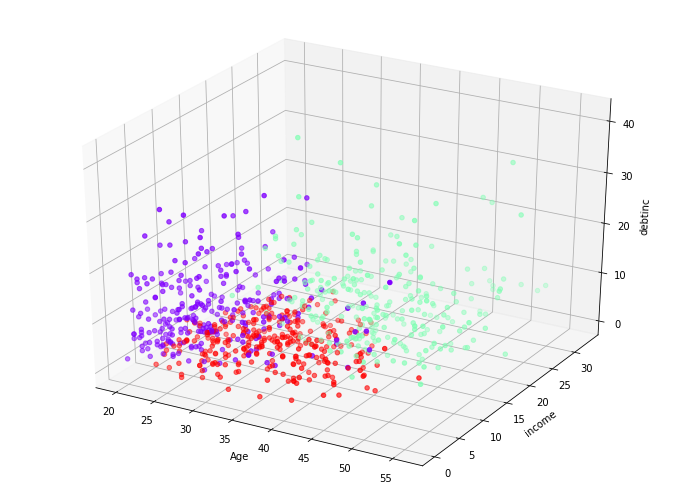

In [ ]:
ax = plt.axes(projection="3d")

ax.scatter3D(Clusters['age'],Clusters['employ'],Clusters['debtinc'],c=kmeans_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('income', linespacing=3.1)
zLabel = ax.set_zlabel('debtinc', linespacing=3.4)
print("K-Means")